# Sources

- https://arxiv.org/pdf/1801.04381
- https://github.com/Shubhamai/pytorch-mobilenet/blob/main/MobileNetV2.py
- https://www.programmerall.com/article/97602304119/
- https://www.kaggle.com/code/sdeagggg/ssd300-with-pytorch
- https://pytorch.org/vision/main/_modules/torchvision/models/detection/ssd.html
- https://pytorch.org/vision/stable/_modules/torchvision/models/detection/ssdlite.html#SSDLite320_MobileNet_V3_Large_Weights

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
from torchvision import tv_tensors

import pytorch_lightning as pl
from torchmetrics.detection.mean_ap import MeanAveragePrecision
from torchmetrics import MetricCollection

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import os
import multiprocessing
# from tqdm import tqdm

from collections import OrderedDict
from math import sqrt

In [2]:
# multiprocessing.set_start_method('spawn')

In [3]:
pl.seed_everything(seed=42)

Seed set to 42


42

In [4]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Backbone

## MobileNetV2

In [5]:
class InvertedResidualBlock(nn.Module):
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        stride: int,
        expansion_factor: int = 6,
    ):
        super().__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.stride = stride
        
        hid_channels: int = int(in_channels * expansion_factor)
        layers = []
        if expansion_factor != 1:
            layers.append(
                nn.Sequential(
                    nn.Conv2d(
                        in_channels=in_channels,
                        out_channels=hid_channels,
                        kernel_size=(1, 1),
                        stride=1,
                        bias=False,
                    ),
                    nn.BatchNorm2d(hid_channels),
                    nn.ReLU6(inplace=True),
                )
            )
        layers += [
            nn.Sequential(
                nn.Conv2d(
                    in_channels=hid_channels,
                    out_channels=hid_channels,
                    kernel_size=(3, 3),
                    padding=1,
                    stride=stride,
                    groups=hid_channels,
                    bias=False,
                ),
                nn.BatchNorm2d(hid_channels),
                nn.ReLU6(inplace=True),
            ),
            nn.Sequential(
                nn.Conv2d(
                    in_channels=hid_channels,
                    out_channels=out_channels,
                    kernel_size=(1, 1),
                    stride=1,
                    bias=False,
                ),
                nn.BatchNorm2d(out_channels),
            )
        ]

        self.conv = nn.Sequential(*layers)

        self.residual = (stride == 1) and (in_channels == out_channels)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        if self.residual:
            return x + self.conv(x)
        return self.conv(x)

In [6]:
class MobileNetV2(nn.Module):
    def __init__(
        self,
        in_channels: int,
        num_classes: int,
    ):
        super().__init__()

        # in_channels, expansion_factor, out_channels, repeated, stride
        config = (
            (32, 1, 16, 1, 1),
            (16, 6, 24, 2, 2),
            (24, 6, 32, 3, 2),
            (32, 6, 64, 4, 2),
            (64, 6, 96, 3, 1),
            (96, 6, 160, 3, 2),
            (160, 6, 320, 1, 1),
        )

        conv_1 = nn.Sequential(
            nn.Conv2d(
                in_channels=in_channels,
                out_channels=32,
                kernel_size=(3, 3),
                stride=2,
                padding=1,
                bias=False,
            ),
            nn.BatchNorm2d(32),
            nn.ReLU6(inplace=True),
        )

        self.features = nn.ModuleList([conv_1])
        for in_channels, exp_factor, out_channels, repeat, stride in config:
            # The first layer of each sequence has a stride 's' and all others use stride 1
            for r in range(repeat):
                self.features.append(
                    InvertedResidualBlock(
                        in_channels=in_channels,
                        out_channels=out_channels,
                        stride=stride,
                        expansion_factor=exp_factor,
                    )
                )
                in_channels = out_channels
                stride = 1

        conv_2 = nn.Sequential(
            nn.Conv2d(
                in_channels=320,
                out_channels=1280,
                kernel_size=(1, 1),
                stride=1,
                padding=0,
                bias=False,
            ),
            nn.BatchNorm2d(1280),
            nn.ReLU6(inplace=True),
        )
        self.features.append(conv_2)

        self.avg_pool = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(start_dim=1),
        )

        self.classifier = nn.Sequential(
            nn.Dropout(p=0.2),
            nn.Linear(
                in_features=1280,
                out_features=num_classes,
            )
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:        
        for block in self.features:
            x = block(x)

        out = self.avg_pool(x)
        out = self.classifier(out)
        
        return out

In [7]:
class ExtraBlock(nn.Module):
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
    ):
        super().__init__()
        intermediate_channels = out_channels // 2
        self.conv = nn.Sequential(
            # 1x1 projection to half output channels
            nn.Conv2d(
                in_channels=in_channels,
                out_channels=intermediate_channels,
                kernel_size=1,
                stride=1,
                bias=False,
            ),
            nn.BatchNorm2d(intermediate_channels),
            nn.ReLU6(inplace=True),
            # 3x3 depthwise with stride 2 and padding 1
            nn.Conv2d(
                in_channels=intermediate_channels,
                out_channels=intermediate_channels,
                kernel_size=3,
                stride=2,
                padding=1,
                groups=intermediate_channels,
                bias=False,
            ),
            nn.BatchNorm2d(intermediate_channels),
            nn.ReLU6(inplace=True),
            # 1x1 projetion to output channels
            nn.Conv2d(
                in_channels=intermediate_channels,
                out_channels=out_channels,
                kernel_size=1,
                bias=False,
            ),
            nn.BatchNorm2d(out_channels),
            nn.ReLU6(inplace=True),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.conv(x)

In [8]:
class PredictionBlock(nn.Module):
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        kernel_size: int,
    ):
        super().__init__()
        self.conv = nn.Sequential(
            # 3x3 depthwise with stride 1 and padding 1
            nn.Conv2d(
                in_channels=in_channels,
                out_channels=in_channels,
                kernel_size=kernel_size,
                groups=in_channels,
                padding=1,
                stride=1,
                bias=False,
            ),
            nn.BatchNorm2d(in_channels, eps=0.001, momentum=0.03),
            nn.ReLU6(inplace=True),
            # 1x1 projetion to output channels
            nn.Conv2d(
                in_channels=in_channels,
                out_channels=out_channels,
                kernel_size=1,
                bias=True,
            ),
        )
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.conv(x)

In [9]:
class SSDLiteFeatureExtractorMobileNet(nn.Module):
    def __init__(
        self,
        backbone: list[nn.Module],
        c4_pos: int,
        width_mult: float = 1.0,
        min_depth: int = 16,
    ):
        super().__init__()
        self.features = nn.Sequential(
            backbone[:c4_pos],  # from start until C4 expansion layer
            backbone[c4_pos:],  # from C4 depthwise until end
        )

        get_depth = lambda d: max(min_depth, int(d * width_mult))
        extra = nn.ModuleList(
            [
                ExtraBlock(1280, get_depth(512)),
                ExtraBlock(get_depth(512), get_depth(256)),
                ExtraBlock(get_depth(256), get_depth(256)),
                ExtraBlock(get_depth(256), get_depth(128)),
            ]
        )
        self.extra = extra

    def forward(self, x: torch.Tensor) -> list[torch.Tensor]:
        # Get feature maps from backbone and extra
        output = []
        for module in self.features:
            for block in module:
                x = block(x)
            output.append(x)

        for block in self.extra:
            x = block(x)
            output.append(x)

        return output

In [10]:
class SSDLiteHead(nn.Module):
    def __init__(
        self,
        in_channels: list[int],
        num_anchors: list[int],
        num_classes: int,
    ):
        super().__init__()
        self.num_classes = num_classes
        
        self.classification_head = nn.ModuleList([
            PredictionBlock(
                in_channels=channels,
                out_channels=num_classes * anchors,
                kernel_size=3,
            ) for channels, anchors in zip(in_channels, num_anchors)
        ])
        
        self.regression_head = nn.ModuleList([
            PredictionBlock(
                in_channels=channels,
                out_channels=4 * anchors,
                kernel_size=3,
            ) for channels, anchors in zip(in_channels, num_anchors)
        ])

    def forward(self, x: list[torch.Tensor]) -> dict[str, torch.Tensor]:
        batch_size = x[0].size(0)
        
        regression_out = []
        classification_out = []

        for feature_map, cls_block, reg_block in zip(x, self.classification_head, self.regression_head):            
            classification_out.append(
                cls_block(feature_map)
                .permute(0, 2, 3, 1)
                .contiguous()
                .view(batch_size, -1, self.num_classes)
            )
            regression_out.append(
                reg_block(feature_map)
                .permute(0, 2, 3, 1)
                .contiguous()
                .view(batch_size, -1, 4)
            )
        
        return {
            'bbox_regression': torch.cat(regression_out, dim=1),
            'cls_logits': torch.cat(classification_out, dim=1),
        }

In [11]:
class PriorBoxGenerator:
    def __init__(
        self,
        feature_map_dims: list,
        scales: list,
        aspect_ratios: list,
        clip: bool = True
    ):
        self.feature_map_dims = feature_map_dims
        self.scales = scales
        self.aspect_ratios = aspect_ratios
        self.clip = clip

    def generate_boxes(self):
        prior_boxes = []
        # for every feature map
        for k, fmap_dim in enumerate(self.feature_map_dims):
            # for every meta-pixel in feature map
            for i in range(fmap_dim):
                for j in range(fmap_dim):
                    # evaluate center of meta-pixel
                    cx = (j + 0.5) / fmap_dim
                    cy = (i + 0.5) / fmap_dim

                    # add priors for square shape (1 and 1')
                    prior_boxes.append([cx, cy, self.scales[k], self.scales[k]])
                    additional_scale = self.scales[k] * self.scales[k+1] if (k < len(self.scales) - 1) else 1.0
                    prior_boxes.append([cx, cy, sqrt(additional_scale), sqrt(additional_scale)])

                    # evaluate width and height according to the aspect_ratio
                    for ar in self.aspect_ratios[k]:
                        prior_boxes.append([cx, cy, self.scales[k] * sqrt(ar), self.scales[k] / sqrt(ar)])
                        prior_boxes.append([cx, cy, self.scales[k] / sqrt(ar), self.scales[k] * sqrt(ar)])

        prior_boxes = torch.FloatTensor(prior_boxes)
        
        if self.clip:
            prior_boxes.clamp_(0.0, 1.0)

        return prior_boxes

In [12]:
class PostProcessor:
    def __init__(
        self,
        priors_cxcy: torch.Tensor,
        min_score: float,
        max_overlap: float,
        top_k: int,
    ):
        self.priors_cxcy = priors_cxcy
        self.min_score = min_score
        self.max_overlap = max_overlap
        self.top_k = top_k

    def detect(self, head_output: dict[str, torch.Tensor]) -> list[dict[str, torch.Tensor]]:
        bbox_regression = head_output['bbox_regression']
        pred_scores = F.softmax(head_output['cls_logits'], dim=-1)

        batch_size = bbox_regression.size(0)
        n_priors = bbox_regression.size(1)
        n_classes = pred_scores.size(2)
        device = bbox_regression.device
        
        detections = []

        for i in range(batch_size):
            boxes = cxcy_to_xy(gcxgcy_to_cxcy(bbox_regression[i], self.priors_cxcy))
        
            image_boxes = []
            image_scores = []
            image_labels = []
            # loop without background class
            for label in range(1, n_classes):
                # choose class
                score = pred_scores[i][:, label]
                keep_idxs = score > self.min_score
                n_above_min_score = keep_idxs.sum().item()

                if n_above_min_score == 0:
                    continue
    
                score = score[keep_idxs]
                box = boxes[keep_idxs]

                # sort by confidence
                score, sort_idx = score.sort(dim=0, descending=True)
                box = box[sort_idx]
                
                # nms
                overlap = jaccard_overlap(box, box)
                suppress = torch.zeros((n_above_min_score), dtype=torch.bool, device=device)
                for b in range(box.size(0)):
                    if suppress[b]:
                        continue

                    suppress = suppress | (overlap[b] > self.max_overlap)
                    suppress[b] = False
    
                image_boxes.append(box[~suppress])
                image_scores.append(score[~suppress])
                image_labels.append(torch.full_like(score[~suppress], fill_value=label, dtype=torch.int64, device=device))

            # if did not find class detections, paste background box
            if len(image_boxes) == 0:
                image_boxes.append(torch.tensor([[0, 0, 1, 1]], dtype=torch.float32, device=device))
                image_scores.append(torch.tensor([0,], dtype=torch.float32, device=device))
                image_labels.append(torch.tensor([0,], dtype=torch.int64, device=device))
    
            image_boxes = torch.cat(image_boxes, dim=0)
            image_scores = torch.cat(image_scores, dim=0)
            image_labels = torch.cat(image_labels, dim=0)
            n_objects = image_boxes.size(0)

            keep = min(self.top_k, n_objects) if self.top_k > 0 else n_objects
            detections.append(
                {
                    'boxes': image_boxes[:keep],
                    'scores': image_scores[:keep],
                    'labels': image_labels[:keep],
                }
            )

        return detections

In [13]:
class SSDLite(nn.Module):
    def __init__(
        self,
        backbone: list[nn.Module],
        c4_pos: int,
        num_classes: int,
        min_score: float = 0.3,
        max_overlap: float = 0.6,
        top_k: int = -1,
    ):
        super().__init__()
        
        self.ssd_feature_extractor = SSDLiteFeatureExtractorMobileNet(
            backbone=backbone,
            c4_pos=c4_pos,
        )

        self.ssd_head = SSDLiteHead(
            in_channels=[96, 1280, 512, 256, 256, 128],
            num_anchors=[6, 6, 6, 6, 6, 6],
            num_classes=num_classes
        )

        self.prior_generator = PriorBoxGenerator(
            feature_map_dims=[20, 10, 5, 3, 2, 1],
            scales=[0.1, 0.2, 0.375, 0.55, 0.725, 0.9],
            aspect_ratios=[[2, 3], [2, 3], [2, 3], [2, 3], [2, 3], [2, 3]],
            clip=True,
        )

        self.postprocess_detector = PostProcessor(
            priors_cxcy=self.prior_generator.generate_boxes().to(device),
            min_score=min_score,
            max_overlap=max_overlap,
            top_k=top_k,
        )

    def forward(self, x: torch.Tensor) -> dict[str, torch.Tensor]:
        feature_maps: list[torch.Tensor] = self.ssd_feature_extractor(x)
        anchors: dict = self.ssd_head(feature_maps)

        return anchors

In [14]:
def xy_to_cxcy(xy: torch.Tensor) -> torch.Tensor:
    """
    (x_min, y_min, x_max, y_max) -> (c_x, c_y, w, h)
    :param xy: Tensor of shape (n_priors, 4)
    """
    return torch.cat([
        (xy[:, 2:] + xy[:, :2]) / 2,  # c_x, c_y
         xy[:, 2:] - xy[:, :2]  # w, h
    ], dim=1)  

def cxcy_to_xy(cxcy: torch.Tensor) -> torch.Tensor:
    """
    (c_x, c_y, w, h) -> (x_min, y_min, x_max, y_max)
    :param cxcy: Tensor of shape (n_priors, 4)
    """
    return torch.cat([
        cxcy[:, :2] - (cxcy[:, 2:] / 2),  # x_min, y_min
        cxcy[:, :2] + (cxcy[:, 2:] / 2)  # x_max, y_max
    ], dim=1)


def cxcy_to_gcxgcy(cxcy: torch.Tensor, priors_cxcy: torch.Tensor, variance: tuple = (0.1, 0.2)) -> torch.Tensor:
    """
    encoding в координаты якоря
    (c_x, c_y, w, h) -> (g_c_x, g_c_y,  g_w, g_h)
    :param cxcy: Tensor of shape (n_priors, 4)
    :param priors_cxcy: Tensor of shape (n_priors, 4)
    :param variance: tuple as (0.1, 0.2). Major goal of including the variance is to scale the gradient
    """
    return torch.cat([
        (cxcy[:, :2] - priors_cxcy[:, :2]) / (priors_cxcy[:, 2:] * variance[0]),  # g_c_x, g_c_y
        torch.log(cxcy[:, 2:] / (priors_cxcy[:, 2:] + 1e-8)) / variance[1]  # g_w, g_h
    ], dim=1)


def gcxgcy_to_cxcy(gcxgcy: torch.Tensor, priors_cxcy: torch.Tensor, variance: tuple = (0.1, 0.2)) -> torch.Tensor:
    """
    decoding из координат якоря в центральные
    (g_c_x, g_c_y,  g_w, g_h) -> (c_x, c_y, w, h)
    :param gcxgcy: Tensor of shape (n_priors, 4)
    :param priors_cxcy: Tensor of shape (n_priors, 4)
    :param variance: tuple as (0.1, 0.2). Major goal of including the variance is to scale the gradient
    """
    return torch.cat([
        gcxgcy[:, :2] * priors_cxcy[:, 2:] * variance[0] + priors_cxcy[:, :2],  # c_x, c_y
        torch.exp(gcxgcy[:, 2:] * variance[1]) * priors_cxcy[:, 2:]  # w, h
    ], dim=1)

## Jaccard Overlap (IoU)

$$
w_c=x_2-x_1
$$
$$
x_2=\min\{x_{max0},\ x_{max1}\}
$$
$$
x_1=\max\{x_{min0},\ x_{min1} \}
$$

$$
h_c=y_2-y_1
$$
$$
y_2=\min\{y_{max0},\ y_{max1}\}
$$
$$
y_1=\max\{y_{min0},\ y_{min1} \}
$$

$$
intersection = w_c * h_c
$$

In [15]:
def jaccard_overlap(priors_xy: torch.Tensor, boxes: torch.Tensor) -> torch.Tensor:
    """
    Analog from torchvision.ops.boxes import box_iou
    :param priors_xy: tensor of shape (A, 4) with priors coordinates (x_min, y_min, x_max, y_max)
    :param boxes: tensor of shape (B, 4) with bound box coordinates (x_min, y_min, x_max, y_max)
    """
    A = priors_xy.size(0)
    B = boxes.size(0)

    # evaluate pairwise intersection
    xy_min = torch.maximum(
        priors_xy[:, :2].unsqueeze(1).expand(A, B, 2),
        boxes[:, :2].unsqueeze(0).expand(A, B, 2),
    )
    xy_max = torch.minimum(
        priors_xy[:, 2:].unsqueeze(1).expand(A, B, 2),
        boxes[:, 2:].unsqueeze(0).expand(A, B, 2),
    )
    xy_diff = torch.clamp(xy_max - xy_min, min=0)
    intersection = xy_diff[:, :, 0] * xy_diff[:, :, 1]  # (A, B)

    # evaluate pairwise union
    area_of_priors = (priors_xy[:, 2] - priors_xy[:, 0]) * (priors_xy[:, 3] - priors_xy[:, 1])
    area_of_boxes = (boxes[:, 2] - boxes[:, 0]) * (boxes[:, 3] - boxes[:, 1])

    union = area_of_priors.unsqueeze(1).expand(A, B) + area_of_boxes.unsqueeze(0).expand(A, B) - intersection

    return intersection / union

In [16]:
class MultiBoxLoss(nn.Module):
    def __init__(
        self,
        priors_cxcy: torch.Tensor,
        background_label: int = 0,
        iou_threshold: float = 0.5,
        neg_pos_ratio: int = 3,
        alpha: float = 1.0,
    ):
        super().__init__()

        self.priors_cxcy = priors_cxcy
        self.priors_xy = cxcy_to_xy(priors_cxcy)

        self.background_label = background_label
        self.iou_threshold = iou_threshold
        self.neg_pos_ratio = neg_pos_ratio
        self.alpha = alpha

        self.l1_loss = nn.L1Loss(reduction='mean')
        self.cross_entropy_loss = nn.CrossEntropyLoss(reduction='none')

        self.loss = None

    def forward(
        self,
        head_outputs: dict[str, torch.Tensor],
        boxes: list[torch.Tensor],
        labels: list[torch.Tensor],
    ):
        bbox_regression = head_outputs['bbox_regression']
        cls_logits = head_outputs['cls_logits']

        device = cls_logits.device
        batch_size = cls_logits.size(0)
        n_priors = cls_logits.size(1)
        num_classes = cls_logits.size(2)

        true_locs = torch.zeros((batch_size, n_priors, 4), dtype=torch.float32, device=device)
        true_classes = torch.zeros((batch_size, n_priors), dtype=torch.int64, device=device)

        for i in range(batch_size):
            n_objects = boxes[i].size(0)
            overlap = jaccard_overlap(priors_xy=self.priors_xy, boxes=boxes[i])  # (n_priors, n_objects)

            # for each prior find the best matched GT object
            overlap_for_each_prior, objects_for_each_prior = overlap.max(dim=1)

            # we need match with all GT objects, but there is two bad situation:
            # (1) GT object did not match with any prior
            # (2) IoU between GT object and matched prior lower than threshold
            
            # for each GT object find the best match prior
            _, prior_for_each_object = overlap.max(dim=0)

            # manual set GT object for prior (solving (1))
            objects_for_each_prior[prior_for_each_object] = torch.arange(n_objects, device=device)
            # manual set high IoU (solving (2))
            overlap_for_each_prior[prior_for_each_object] = 1.0

            # find label for each prior
            label_for_each_prior = labels[i][objects_for_each_prior]

            # set background label for low iou
            label_for_each_prior[overlap_for_each_prior < self.iou_threshold] = self.background_label

            # save final prediction for priors
            true_classes[i] = label_for_each_prior
            true_locs[i] = cxcy_to_gcxgcy(xy_to_cxcy(boxes[i][objects_for_each_prior]), self.priors_cxcy)
            
        # find positive priors
        # exclude background class
        positive_priors = (true_classes != self.background_label)  # (batch_size, n_priors)
        
        # localization loss
        # evaluate only for positive priors
        loc_loss = self.l1_loss(bbox_regression[positive_priors], true_locs[positive_priors])

        # confidence loss
        n_positives = positive_priors.sum(dim=1, keepdim=True)
        n_hard_negatives = self.neg_pos_ratio * n_positives  # (batch_size, 1)

        # evaluate loss for all priors
        cls_loss = self.cross_entropy_loss(
            cls_logits.reshape(-1, num_classes),
            true_classes.reshape(-1)
        ).reshape(batch_size, n_priors)  # (batch_size, n_priors)

        negative_cls_loss = cls_loss.clone()
        # use -inf to detect positive values
        negative_cls_loss[positive_priors] = - torch.inf
        negative_values, negative_idx = negative_cls_loss.sort(dim=1, descending=True)
        background_idxs = negative_idx.sort(1)[1] < n_hard_negatives

        # sum positive and negative loss
        conf_loss = (cls_loss[positive_priors].sum() + cls_loss[background_idxs].sum()) / n_positives.sum()

        self.loss = conf_loss + self.alpha * loc_loss

        return self.loss

    def backward(self, retain_graph=True):
        self.loss.backward(retain_graph=retain_graph)
        return self.loss

# Dataset

In [17]:
import json
from PIL import Image
import torchvision
from torch.utils.data import Dataset, DataLoader

from torchvision.transforms import v2

In [18]:
def convert_box_point(box):
    return [box[0], box[1], box[0]+box[2], box[1]+box[3]]

In [19]:
with open('../data/coco2017/annotations/instances_train2017.json', 'r') as file:
    train_annot = json.load(file)
with open('../data/coco2017/annotations/instances_val2017.json', 'r') as file:
    valid_annot = json.load(file)

In [20]:
class COCODataset(Dataset):
    def __init__(self, annot, path, transforms = None):
        self.annot = annot
        self.path = path

        class_names = dict()
        for cat in train_annot['categories']:
            class_names[cat['id']] = cat['name']

        images = dict()
        for img in annot['images']:    
            images[img['id']] = {
                'file_name': img['file_name'],
                'height': img['height'],
                'width': img['width'],
                'boxes': [],
                'labels': [],
                'classes': [],
            }

        for an in annot['annotations']:
            # check width and height box gt 0
            if (an['bbox'][2] > 0) and (an['bbox'][3] > 0):
                images[an['image_id']]['boxes'].append(convert_box_point(an['bbox']))
                images[an['image_id']]['labels'].append(an['category_id'])
                images[an['image_id']]['classes'].append(class_names[an['category_id']])

        broken = []
        for k, v in images.items():
            if len(v['boxes']) + len(v['labels']) < 1:
                broken.append(k)
            if len(v['boxes']) != len(v['labels']):
                broken.append(k)
        print(len(broken))

        for b in broken:
            del(images[b])

        self.objects = images
        self.image_idx = {i: k for i, k in enumerate(images.keys())}
        self.class_names = class_names
        self.transforms = transforms

    def __getitem__(self, idx: int):
        image_id = self.image_idx[idx]
        
        image = Image.open(
            os.path.join(self.path, self.objects[image_id]['file_name'])
        ).convert('RGB')

        labels = torch.tensor(self.objects[image_id]['labels'], dtype=torch.int64)        
        
        boxes = tv_tensors.BoundingBoxes(
            self.objects[image_id]['boxes'],
            format="XYXY",
            canvas_size=(image.height, image.width),  # Height and width
        )

        categories = self.objects[image_id]['classes']
        
        target = {
            'boxes': boxes,
            'labels': labels,
            'categories': categories,
        }

        if self.transforms is not None:
            image, target = self.transforms(image, target)
        
        return image, target

    def __len__(self) -> int:
        return len(self.objects)

In [21]:
train_transforms = v2.Compose(
    [
        v2.ToImage(),
        v2.Resize((320, 320)),
        v2.RandomHorizontalFlip(p=0.3),
        v2.RandomGrayscale(p=0.1),
        v2.ToDtype(torch.float32, scale=True),
    ]
)

val_transforms = v2.Compose(
    [
        v2.ToImage(),
        v2.Resize((320, 320)),
        v2.ToDtype(torch.float32, scale=True),
    ]
)

In [22]:
train_dataset = COCODataset(train_annot, '../data/coco2017/train2017/', train_transforms)
valid_dataset = COCODataset(valid_annot, '../data/coco2017/val2017/', val_transforms)

1021
48


In [23]:
len(train_dataset), len(valid_dataset)

(117266, 4952)

In [24]:
def collate_fn(batch):
    images = []
    targets = {'boxes': [], 'labels': [], 'categories': []}
    
    for row in batch:
        image, target = row
        images.append(image)
        height, width = target['boxes'].canvas_size
        targets['boxes'].append(target['boxes'])
        targets['labels'].append(target['labels'])
        targets['categories'].append(target['categories'])
    
    return torch.stack(images, dim=0), targets

In [25]:
batch_size = 32
train_loader = DataLoader(
    train_dataset, 
    batch_size=batch_size, 
    collate_fn=collate_fn,
    shuffle=True,
    # num_workers=8,
    # persistent_workers=True,
    # pin_memory=True,
)
val_loader = DataLoader(
    valid_dataset, 
    batch_size=batch_size, 
    collate_fn=collate_fn,
    shuffle=False,
    # num_workers=8,
    # persistent_workers=True,
    # pin_memory=True,
)

In [26]:
for batch in train_loader:
    break

In [27]:
batch[1]['boxes'][0].canvas_size

(320, 320)

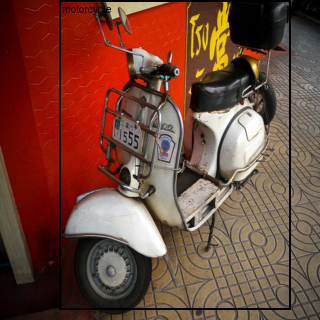

In [28]:
ind = 0
a = torchvision.utils.draw_bounding_boxes(
    image=v2.ToImage()(batch[0][ind]),
    boxes=batch[1]['boxes'][ind],
    labels=batch[1]['categories'][ind],
    width=2,
)

v2.ToPILImage()(a)

# Train

In [29]:
from torch.optim.lr_scheduler import _LRScheduler
from math import cos, pi

class WarmupCosLR(_LRScheduler):
    def __init__(
        self,
        optimizer,
        max_iter,
        warmup_factor=1.0 / 3,
        warmup_iters=500,
        last_epoch=-1,
    ):
        self.max_iter = max_iter
        self.warmup_factor = warmup_factor
        self.warmup_iters = warmup_iters
        super().__init__(optimizer, last_epoch)

    def get_lr(self):
        warmup_factor = 1
        if self.last_epoch < self.warmup_iters:
            alpha = float(self.last_epoch) / self.warmup_iters
            warmup_factor = self.warmup_factor * (1 - alpha) + alpha

        lr_coeff =  (1 + cos(pi * self.last_epoch / self.max_iter)) / 2
        
        return [
            base_lr
            * warmup_factor
            * lr_coeff
            for base_lr in self.base_lrs
        ]

In [30]:
total_losses = []

In [31]:
class SSDLiteLightning(pl.LightningModule):
    def __init__(
        self,
        model,
        criterion,
        t_max,
    ):
        super().__init__()

        self.model = model
        self.criterion = criterion
        self.t_max = t_max

        metric = MetricCollection({
            'map': MeanAveragePrecision(box_format='xyxy', iou_type='bbox'),
        })
        self.train_metric = metric.clone(prefix='train/')
        self.valid_metric = metric.clone(prefix='valid/')
        
        self.save_hyperparameters(ignore=['model', 'criterion'])

    def forward(self, x):
        return self.model(x)
    
    def evaluate(self, batch, metric_func=None):
        images, targets = batch
        boxes = [
            b.to(device) / torch.tensor([b.canvas_size[1], b.canvas_size[0], b.canvas_size[1], b.canvas_size[0]], device=device)
            for b in batch[1]['boxes']
        ]
        labels = [l.to(device) for l in batch[1]['labels']]

        head_output = self.model(images)
        
        loss = self.criterion(
            head_output,
            boxes,
            labels,
        )

        if metric_func is not None:
            # eval metric
            detections = self.model.postprocess_detector.detect(head_output)
    
            preds = []
            for d in detections:
                preds.append({
                    'boxes': d['boxes'] * 320,
                    'labels': d['labels'],
                    'scores': d['scores'],
                })
            target = []
            for b, l in zip(targets['boxes'], targets['labels']):
                target.append({
                    'boxes': b.to(device),
                    'labels': l.to(device),
                })
            metric = metric_func(preds, target)
    
            return loss, metric

        return loss
    
    def training_step(self, batch, batch_idx):
        train_loss = self.evaluate(batch)
        self.log(
            'train_loss',
            train_loss,
            on_step=True,
            on_epoch=True,
            prog_bar=True,
            logger=True,
            batch_size=batch_size,
        )
        total_losses.append(train_loss.item())

        lr = self.optimizers().param_groups[0]['lr']  # Get current learning rate
        self.log(
            'lr',
            lr,
            on_step=True,
            on_epoch=True,
            prog_bar=True,
            logger=True,
            batch_size=batch_size,
        )
        
        return train_loss

    def validation_step(self, batch, batch_idx):
        valid_loss, valid_metric = self.evaluate(batch, self.valid_metric)
        self.log(
            'valid_loss',
            valid_loss,
            on_step=False,
            on_epoch=True,
            prog_bar=True,
            logger=True,
            batch_size=batch_size,
        )
        self.log('valid_map_50', valid_metric['valid/map_50'], on_step=False, on_epoch=True, prog_bar=True, logger=True, batch_size=batch_size)
        return valid_loss
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(
            self.model.parameters(),
            lr=0.001,
            weight_decay=0.0005,
        )

        scheduler = WarmupCosLR(
            optimizer=optimizer,
            max_iter=self.t_max,
            warmup_factor=1.0 / 10.0,
            warmup_iters=500,
        )

        return (
            [optimizer],
            [
                {
                    'scheduler': scheduler,
                    'interval': 'step',
                    'frequency': 1,
                }
            ]
        )

In [32]:
device = 'cuda'

In [33]:
num_classes = 91

backbone = MobileNetV2(
    in_channels=3,
    num_classes=num_classes,
).features

weights_backbone = torchvision.models.mobilenet_v2(weights=torchvision.models.MobileNet_V2_Weights.IMAGENET1K_V2)
params = dict()
for target_param, source_param in zip(backbone.state_dict(), weights_backbone.features.state_dict()):
    params[target_param] = weights_backbone.features.state_dict()[source_param]
backbone.load_state_dict(params)

ssdlite = SSDLite(
    backbone=backbone,
    c4_pos=14,
    num_classes=num_classes,
)

criterion = MultiBoxLoss(ssdlite.prior_generator.generate_boxes().to(device))

In [34]:
torch.set_float32_matmul_precision('medium')

In [35]:
num_epochs = 10

trainer = pl.Trainer(
    accelerator='cuda',
    max_epochs=num_epochs,
    accumulate_grad_batches=3,
    precision=32,
    log_every_n_steps=1,
    enable_checkpointing=True,
    enable_progress_bar=True,
    gradient_clip_val=2,
    use_distributed_sampler=True,
)

model = SSDLiteLightning(
    model=ssdlite,
    criterion=criterion,
    t_max=int(len(train_dataset) / batch_size + 1) * num_epochs
)

trainer.fit(
    model,
    train_dataloaders=train_loader,
    val_dataloaders=val_loader,
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
D:\common\Lib\site-packages\pytorch_lightning\trainer\connectors\logger_connector\logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | model        | SSDLite          | 4.4 M  | train
1 | criterion    | MultiBoxLoss     | 0      | train
2 | train_metric | MetricCollection | 0      | train
3 | valid_metric | MetricCollection | 0      | train
-----

Sanity Checking: |                                                                               | 0/? [00:00<…

D:\common\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
D:\common\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=10` reached.


<Axes: >

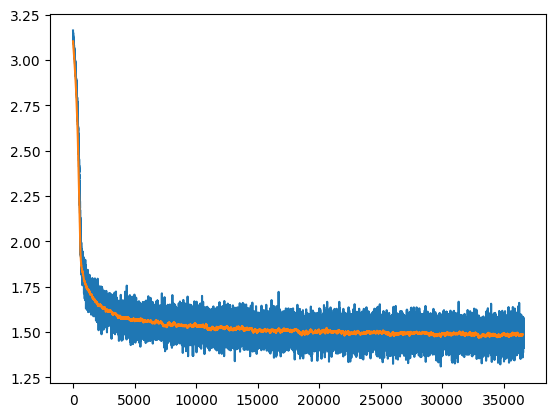

In [36]:
def moving_average(a, n=3):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

avg_loss = moving_average(total_losses, n=32*3)
sns.lineplot(x=np.arange(len(total_losses)), y=np.log(total_losses))
sns.lineplot(x=np.arange(len(avg_loss)), y=np.log(avg_loss))

In [37]:
torch.save(model.model.state_dict(), 'ssdlite_mnv2_mscoco.state_dict')

In [38]:
model.model.eval()

images, targets = batch
head_output = ssdlite(images)
locs = head_output['bbox_regression']
scores = head_output['cls_logits']

In [39]:
postprocess_detector = PostProcessor(
    priors_cxcy=model.model.prior_generator.generate_boxes(),
    min_score=0.3,
    max_overlap=0.6,
    top_k=20,
)

In [40]:
detections = postprocess_detector.detect(head_output)

In [41]:
# detections = model.model.postprocess_detector.detect(head_output)

In [42]:
detections[:5]

[{'boxes': tensor([[ 0.7088, -0.0051,  0.8994,  0.1477],
          [ 0.2473,  0.6838,  0.4694,  0.9764],
          [ 0.2713,  0.7514,  0.4435,  0.9671]], grad_fn=<SliceBackward0>),
  'scores': tensor([0.3328, 0.4707, 0.4362], grad_fn=<SliceBackward0>),
  'labels': tensor([47, 85, 85])},
 {'boxes': tensor([[0.1065, 0.1866, 0.6139, 0.8089]], grad_fn=<SliceBackward0>),
  'scores': tensor([0.5187], grad_fn=<SliceBackward0>),
  'labels': tensor([16])},
 {'boxes': tensor([[0.0067, 0.5502, 0.1383, 0.9637],
          [0.1936, 0.5525, 0.2524, 0.6659],
          [0.3899, 0.5967, 0.7577, 0.7088]], grad_fn=<SliceBackward0>),
  'scores': tensor([0.9714, 0.4433, 0.7706], grad_fn=<SliceBackward0>),
  'labels': tensor([1, 1, 3])},
 {'boxes': tensor([[ 3.4485e-01,  3.3100e-01,  6.4711e-01,  6.9179e-01],
          [-4.4706e-04,  9.6793e-02,  9.9998e-01,  9.6970e-01]],
         grad_fn=<SliceBackward0>),
  'scores': tensor([0.3360, 0.6451], grad_fn=<SliceBackward0>),
  'labels': tensor([54, 67])},
 {'box

In [43]:
detections[1]['boxes'].shape

torch.Size([1, 4])

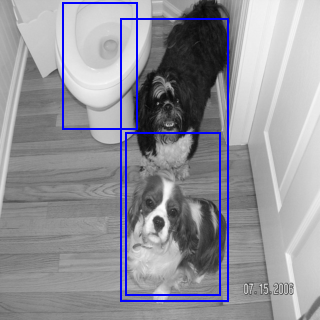

In [44]:
ind = 12

a = torchvision.utils.draw_bounding_boxes(
    image=v2.ToImage()(batch[0][ind]),
    boxes=detections[ind]['boxes'][:5] * 320,
    colors=['blue']*len(detections[ind]['boxes'][:5]),
    width=2,
)

v2.ToPILImage()(a)

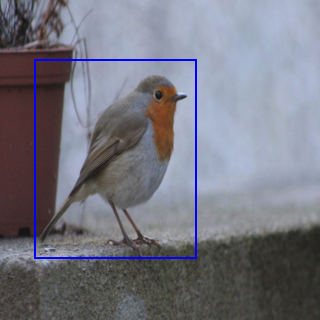

In [45]:
ind = 1

a = torchvision.utils.draw_bounding_boxes(
    image=v2.ToImage()(batch[0][ind]),
    boxes=detections[ind]['boxes'][:5] * 320,
    colors=['blue']*len(detections[ind]['boxes'][:5]),
    width=2,
)

v2.ToPILImage()(a)

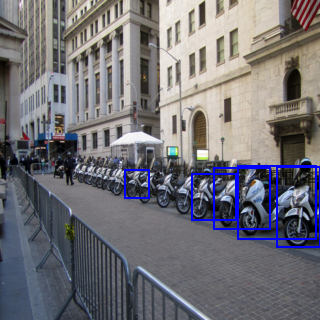

In [48]:
ind = 7

a = torchvision.utils.draw_bounding_boxes(
    image=v2.ToImage()(batch[0][ind]),
    boxes=detections[ind]['boxes'][:5] * 320,
    colors=['blue']*len(detections[ind]['boxes'][:5]),
    width=2,
)

v2.ToPILImage()(a)

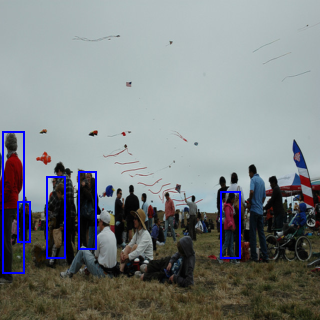

In [49]:
ind = 9

a = torchvision.utils.draw_bounding_boxes(
    image=v2.ToImage()(batch[0][ind]),
    boxes=detections[ind]['boxes'][:5] * 320,
    colors=['blue']*len(detections[ind]['boxes'][:5]),
    width=2,
)

v2.ToPILImage()(a)